Dataset Shape: (3999, 31)

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.20

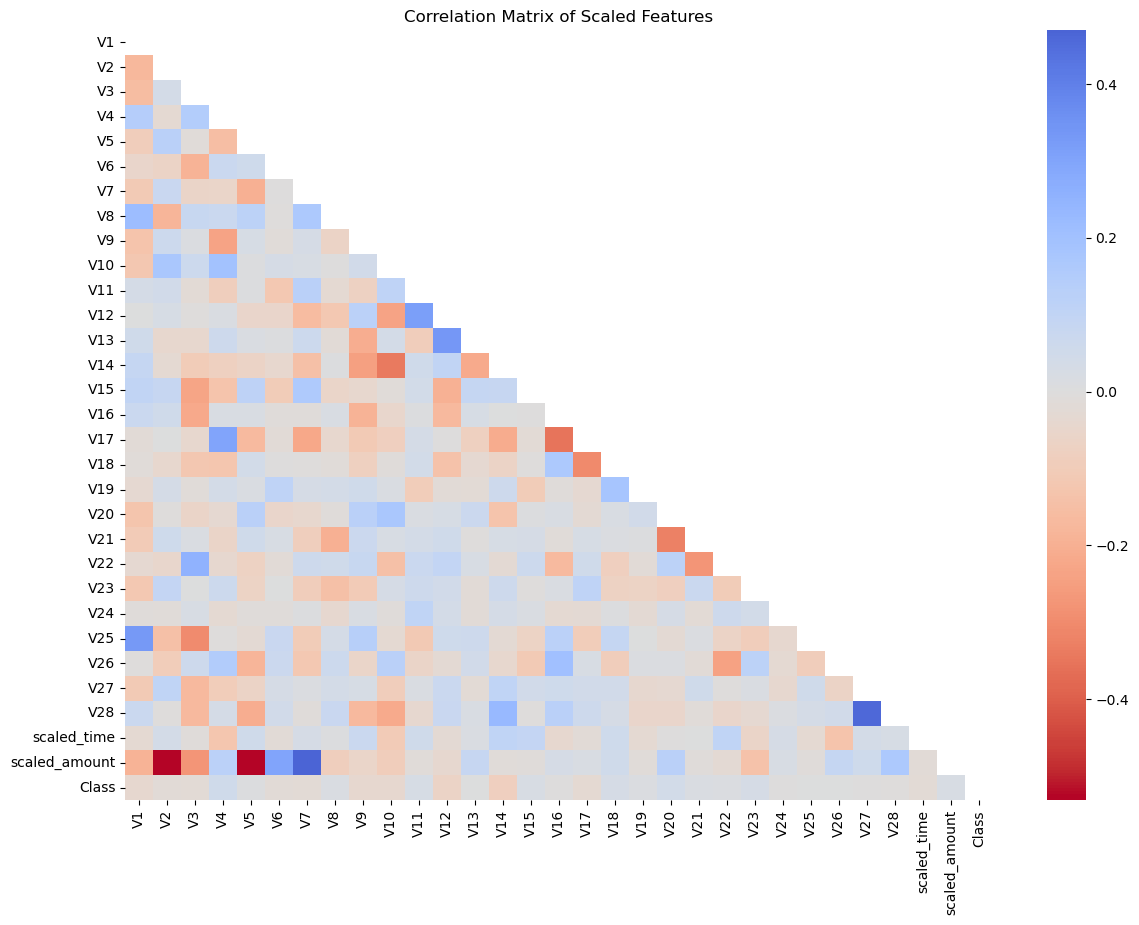

Features Most Correlated with Class (Fraud):
Class            1.000000
V4               0.049355
V20              0.040688
V23              0.029457
V18              0.029298
V11              0.027890
V15              0.023124
scaled_amount    0.020926
V21              0.015200
V8               0.012705
V22              0.010052
V19              0.009212
V5               0.008308
V13              0.004227
V25              0.003713
V26              0.001240
V24             -0.000579
V27             -0.002541
V16             -0.002612
V28             -0.004963
V2              -0.017270
V6              -0.022617
V3              -0.025064
V7              -0.025744
scaled_time     -0.026446
V17             -0.032550
V9              -0.038417
V1              -0.038828
V10             -0.039420
V12             -0.064852
V14             -0.084839
Name: Class, dtype: float64


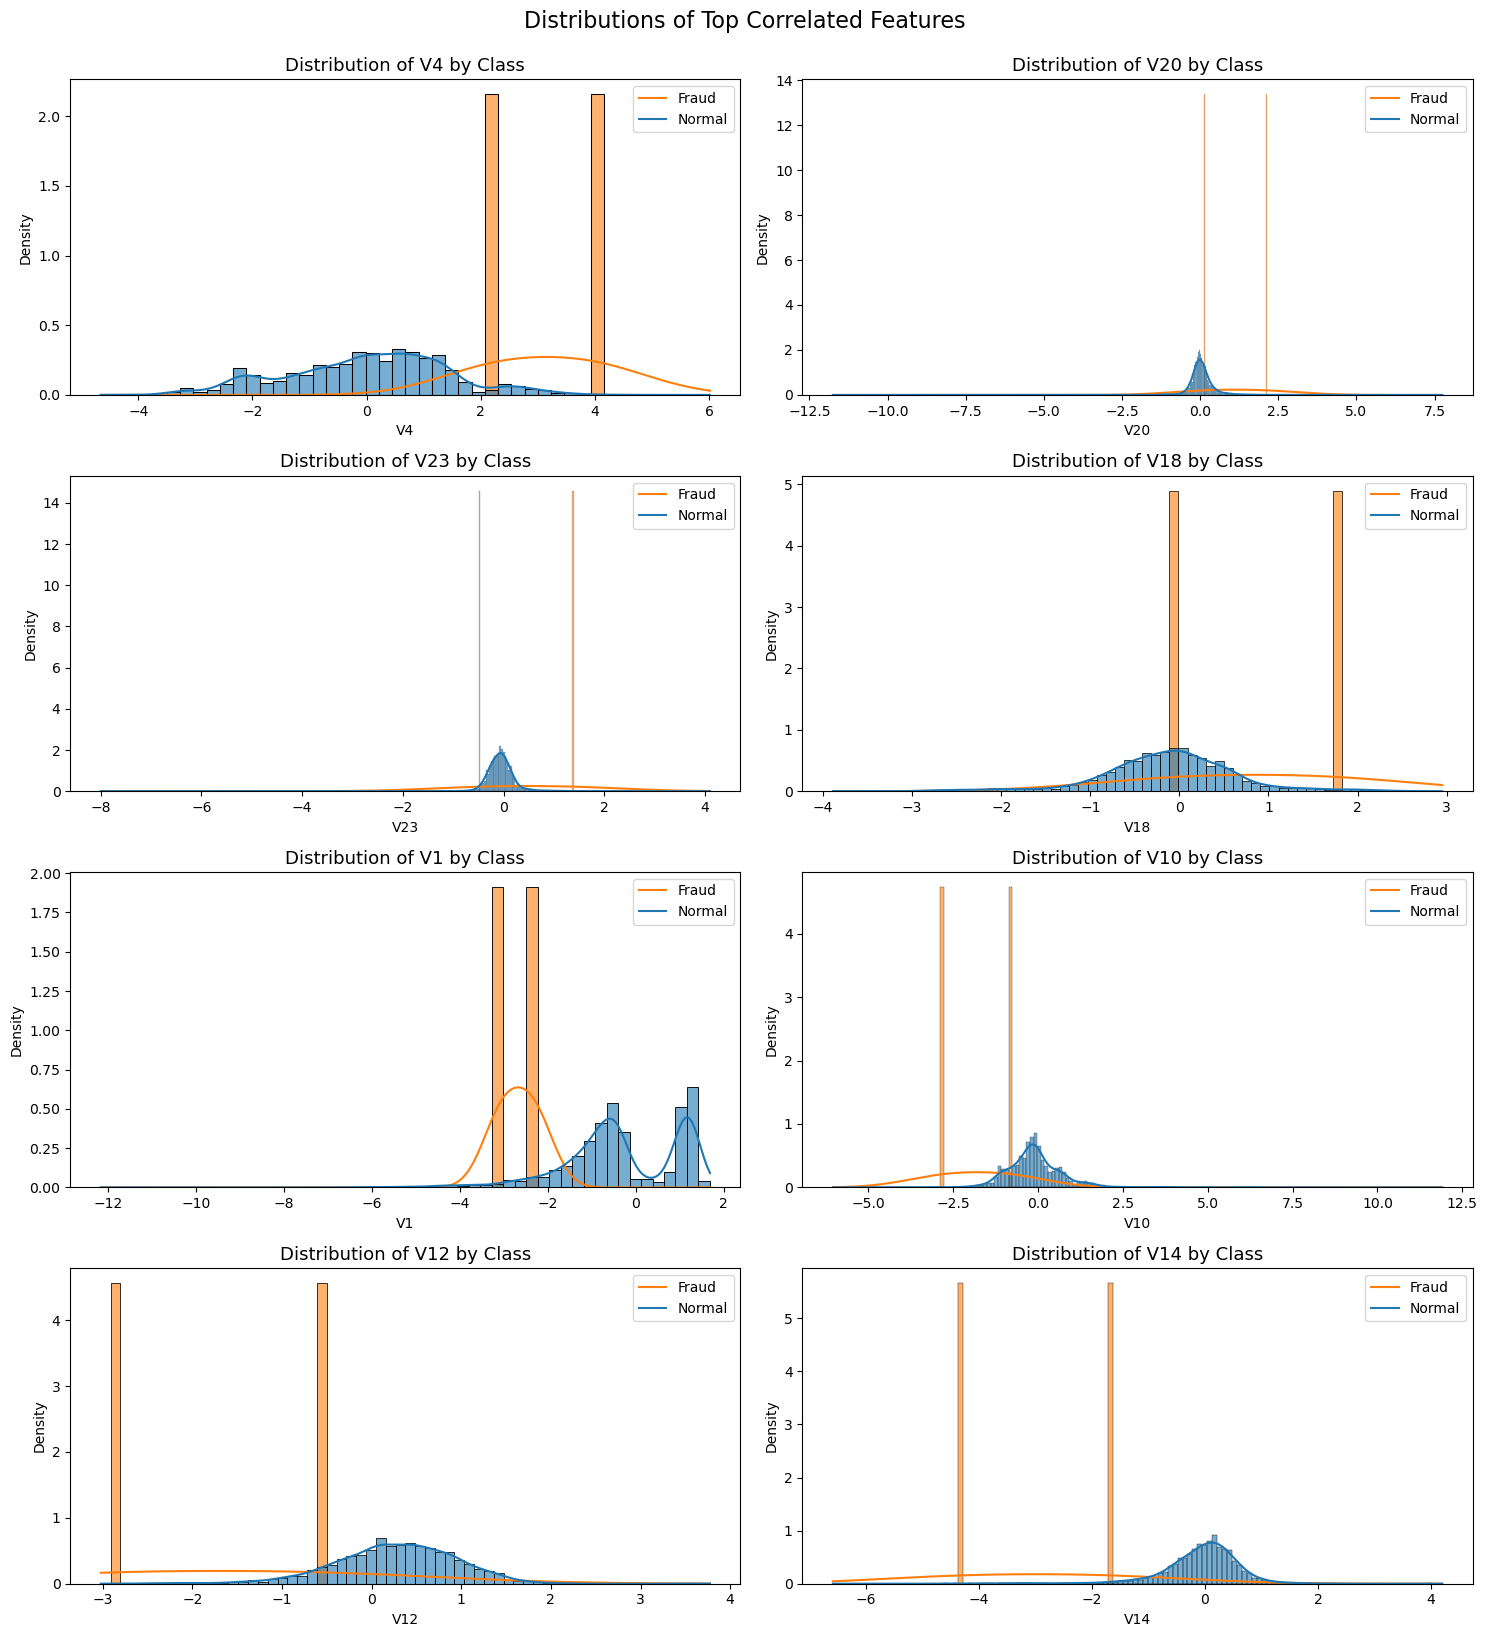

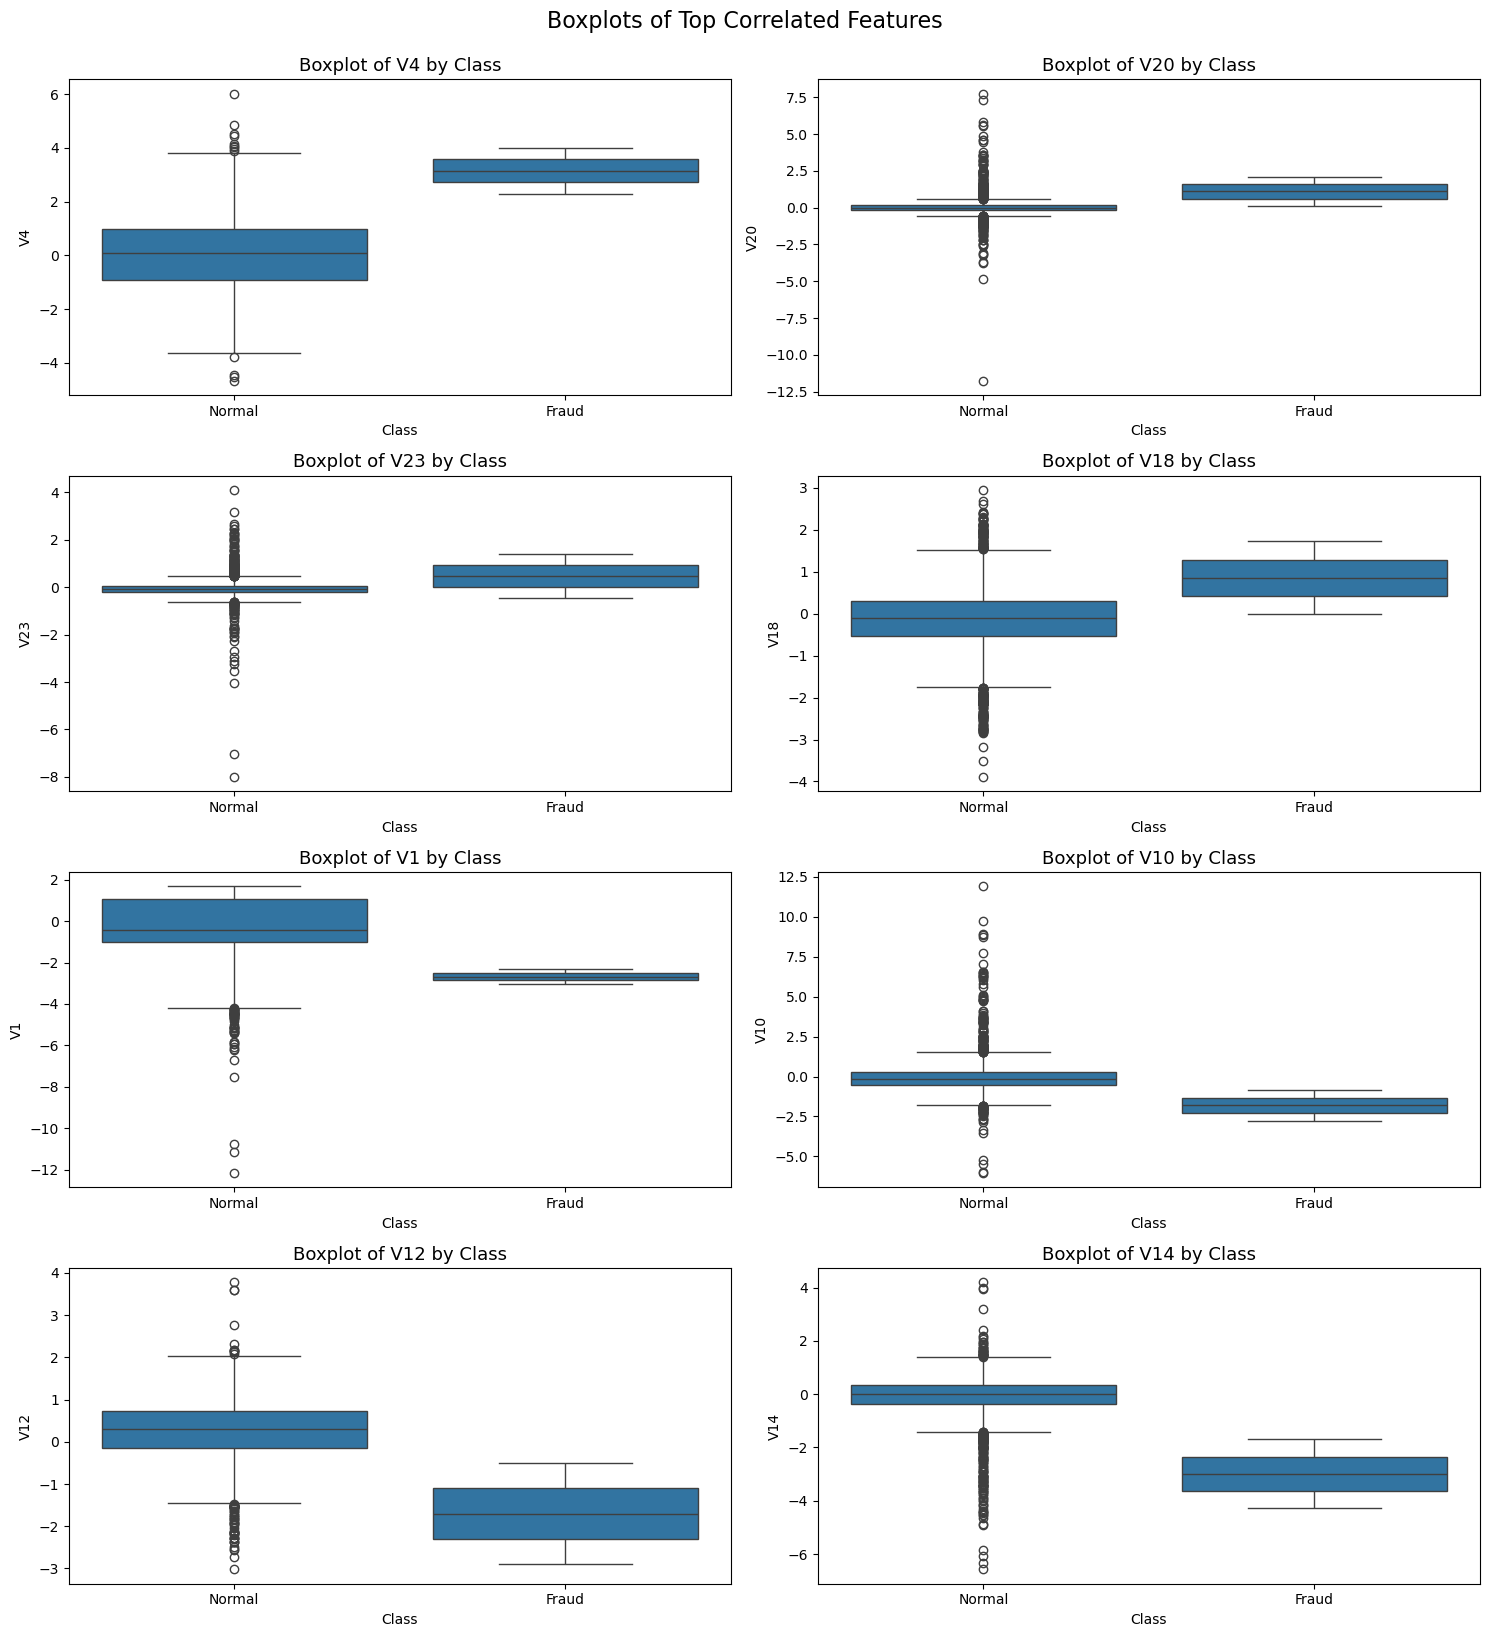

Training set shape: (3199, 30)
Testing set shape: (800, 30)
Fraud ratio in y_train: 0.0006
Fraud ratio in y_test: 0.0000
Under-sampled training data shape: (4, 30)
Class distribution in under-sampled data:
 Class
0    2
1    2
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       800
           1       0.00      0.00      0.00         0

    accuracy                           0.98       800
   macro avg       0.50      0.49      0.49       800
weighted avg       1.00      0.98      0.99       800


Confusion Matrix:


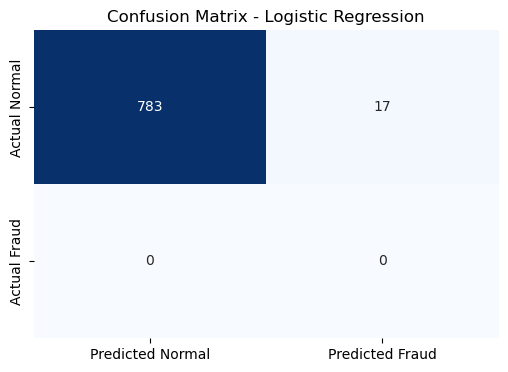

ROC-AUC Score: nan


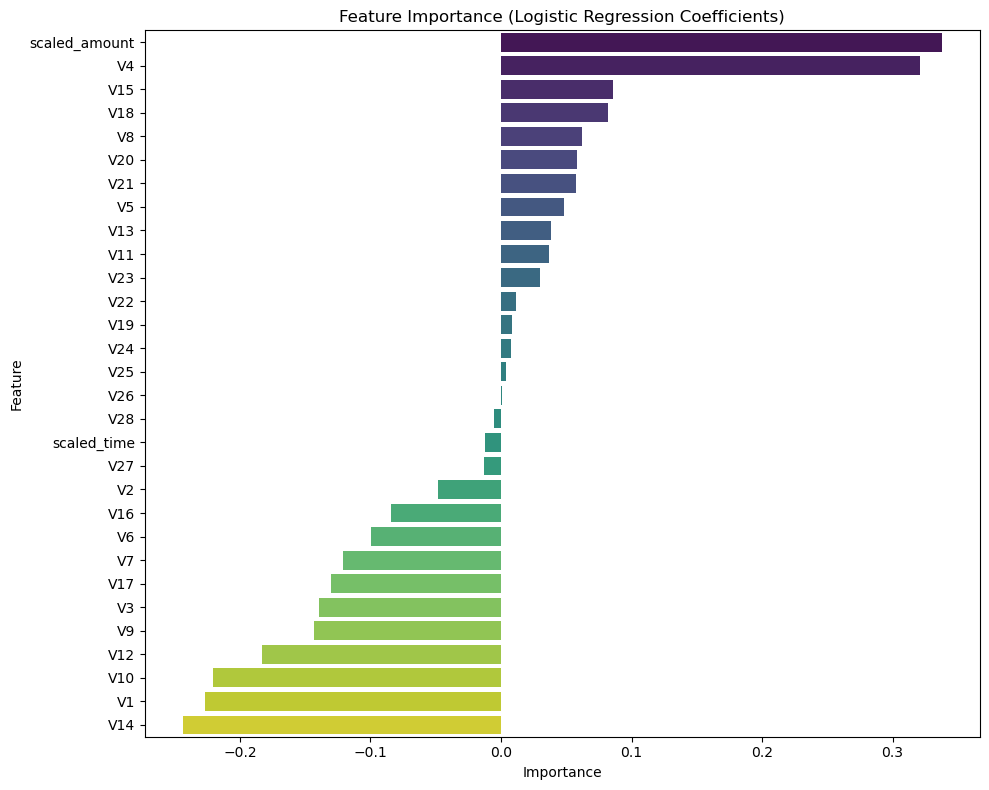

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load the data
df = pd.read_csv(r"C:\Users\FrankJR\Downloads\Portfolio\Credit Card Fraud Dataset\Credit Card Fraud (4000 row).csv")

# Initial inspection
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nClass Distribution:")
print(df['Class'].value_counts())
print(f"\nPercentage of Fraudulent Transactions: {df['Class'].value_counts(normalize=True)[1] * 100:.3f}%")

# Check for missing values
print("Missing Values per Column:")
print(df.isnull().sum())

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
# It's common to have no duplicates in such datasets. If there were, we would drop them.
# df = df.drop_duplicates()

# Since 'Time' might represent the seconds elapsed since the first transaction, its utility is debated.
# Often it's dropped. We'll keep it for this analysis but note that it might not be a strong predictor.
# Create a new dataframe for the cleaned and scaled data
df_clean = df.copy()

# Initialize RobustScaler
rob_scaler = RobustScaler()

# Scale 'Time' and 'Amount'
df_clean['scaled_time'] = rob_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))
df_clean['scaled_amount'] = rob_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns
df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# Let's move the 'Class' column to the end for clarity
class_column = df_clean.pop('Class')
df_clean['Class'] = class_column

print(df_clean.head())

plt.figure(figsize=(14, 10))
# Calculate correlations
corr_matrix = df_clean.corr()
# Create a mask to hide the upper triangle (it's symmetric)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Plot the heatmap
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm_r', annot=False, center=0)
plt.title('Correlation Matrix of Scaled Features')
plt.show()

# Let's look specifically at correlations with the target 'Class'
corr_with_class = corr_matrix['Class'].sort_values(ascending=False)
print("Features Most Correlated with Class (Fraud):")
print(corr_with_class)

# Create a list of the top 8 most correlated features (4 positive, 4 negative)
top_corr_features = corr_with_class.drop('Class').head(4).index.tolist() + corr_with_class.drop('Class').tail(4).index.tolist()

# Plot distributions
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 16))
axes = axes.flatten()

for i, feature in enumerate(top_corr_features):
    sns.histplot(data=df_clean, x=feature, hue='Class', stat='density', common_norm=False, ax=axes[i], kde=True, alpha=0.6)
    axes[i].set_title(f'Distribution of {feature} by Class', fontsize=13)
    axes[i].legend(['Fraud', 'Normal'])

plt.tight_layout()
plt.suptitle('Distributions of Top Correlated Features', fontsize=16, y=1.02)
plt.show()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 16))
axes = axes.flatten()

for i, feature in enumerate(top_corr_features):
    sns.boxplot(data=df_clean, x='Class', y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} by Class', fontsize=13)
    axes[i].set_xticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.suptitle('Boxplots of Top Correlated Features', fontsize=16, y=1.02)
plt.show()

# Separate features and target
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# Split the data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Fraud ratio in y_train: {y_train.mean():.4f}")
print(f"Fraud ratio in y_test: {y_test.mean():.4f}")

# Concatenate training data to undersample
train_df = pd.concat([X_train, y_train], axis=1)

# Separate classes
normal = train_df[train_df.Class == 0]
fraud = train_df[train_df.Class == 1]

# Under-sample the normal class to match the fraud count
normal_undersampled = normal.sample(n=len(fraud), random_state=42)

# Combine back into a single DataFrame
undersampled_df = pd.concat([normal_undersampled, fraud], axis=0)

# Shuffle the dataset
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split back into X and y
X_train_under = undersampled_df.drop('Class', axis=1)
y_train_under = undersampled_df['Class']

print("Under-sampled training data shape:", X_train_under.shape)
print("Class distribution in under-sampled data:\n", y_train_under.value_counts())

# Initialize and train the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_under, y_train_under)

# Predict on the original test set
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Fraud'],
            yticklabels=['Actual Normal', 'Actual Fraud'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Get feature importances (coefficients from logistic regression)
feature_importance = pd.DataFrame({
    'Feature': X_train_under.columns,
    'Importance': log_reg.coef_[0]
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()